# Protótipo de Validação do Modelo com Dados da Literatura

In [1]:
# Importando bibliotecas externas
# matplotlib - biblioteca para criação de gráficos
from matplotlib import pyplot as plt
# pandas - biblioteca para manipulação de dados
import pandas as pd
# numpy - biblioteca numérica em Python
import numpy as np
# scipy - biblioteca direcionada para estudos científicos
import scipy.optimize as optimize

# batchpy - biblioteca com os modelos cinéticos de adsorção
from batchpy import batch as bh

Os dados utilizados na primeira etapa foram retirados do artigo: Effect of concentration in the equilibrium and kinetics of adsorption of acetylsalicylic acid on ZnAl layered double hydroxide. (https://doi.org/10.1016/j.jece.2020.103991) 

![](./asa_removal/img/asa_t_vs_qt.jpg)

Os dados foram retirados dos gráficos utilizando o software: WebPlotDigitizer (https://automeris.io/WebPlotDigitizer/)


In [2]:
# asa = acetylsalicylic acid
dosage_vs_removal = pd.read_csv('./asa_removal/csv/dosage_vs_removal.csv', sep=';')

asa_data ={
    '20mg_1' : pd.read_csv('./asa_removal/csv/qt_vs_time_20mg_1.csv', sep=';'),
    '20mg_2' : pd.read_csv('./asa_removal/csv/qt_vs_time_20mg_2.csv', sep=';'),
    '50mg' : pd.read_csv('./asa_removal/csv/qt_vs_time_50mg.csv', sep=';'),
    '100mg' : pd.read_csv('./asa_removal/csv/qt_vs_time_100mg.csv', sep=';')
}

Uma nova coluna contendo a fração de soluto removida, $v$, é criada a partir da quantidade adsorvida, $q_t$, para cada um dos expertimentos em batelada utilizando-se da expressão
$$
v = 1 - q_t \frac{W}{V_b}
$$
onde $W$ representa a massa de adsorvente na batelada, e $V_b$ o volume da fase bulk.

In [3]:
asa_data['20mg_1'].insert(2, 'v', 1 - asa_data['20mg_1']['q']*3/20, True)
asa_data['20mg_2'].insert(2, 'v', 1 - asa_data['20mg_2']['q']*3/20, True)
asa_data['50mg'].insert(2, 'v', 1 - asa_data['50mg']['q']*3/50, True)
asa_data['100mg'].insert(2, 'v', 1 - asa_data['100mg']['q']*3/100, True)


Segundo o artigo analisado uma série de experimentos foram realizados para definir a razão $W/V_b$ na qual a quantidade de remoção de soluto é máxima. No modelo de difusão intrapartíucula a relação entre a fração $W/V_b$ e a quantidade de soluto removida é dada pelo valor de $\alpha$ definido por
$$
\alpha = \left[\frac{\varepsilon_p}{\rho_p} + (1-\varepsilon_p)K \right] \frac{W}{V_b}
$$

a relação entre alpha e a quantidade removida é dada por

$$
\alpha = \left(\frac{Removal}{100} \right)^{-1} - 1
$$

logo, os dados do gráfico abaixo são utilizados para calcular os valores de $\alpha$ para esse sistema de soluto-adsorvente. Com os valores de $\alpha$ calculados é encontrada uma curva do tipo $y = ax$ que ajusta os dados dos experimentos. 
![](./asa_removal/img/asa_dosage_vs_removal.jpg)

In [4]:
dosage_exp = dosage_vs_removal['dosage']
alpha_exp = 1/(1-dosage_vs_removal['removal']/100) - 1

constants, _ = optimize.curve_fit(lambda x,a: a*x, dosage_exp, alpha_exp)
dosage_fit = [0, 5]
alpha_fit = constants*dosage_fit

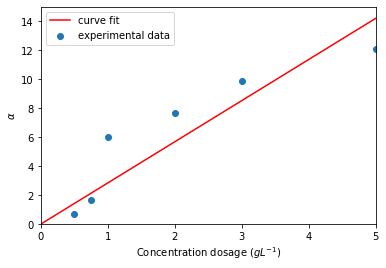

In [5]:
# plot the results
plt.scatter(dosage_exp, alpha_exp, label='experimental data')
plt.plot(dosage_fit, alpha_fit, label='curve fit', color='r')

# set x and y axis labels
plt.xlabel(r'Concentration dosage $(g L^{-1})$')
plt.ylabel(r'$\alpha$')

# set x and y limits 
plt.xlim(0,5)
plt.ylim(0,15)

plt.legend()
plt.show()

In [6]:

def func(x, bi, D_R2):
    v=np.zeros(x.shape)
    eps = 1e-6
    s=2
    a = alpha_exp[4]
    t = x * D_R2
    v = bh.batch_bulk(t,bi,a,s,eps)
    return v

x_exp = (asa_data['20mg_1']['t'].append(asa_data['20mg_2']['t']))
x_exp = x_exp.reset_index()['t']
y_exp = (asa_data['20mg_1']['v'].append(asa_data['20mg_2']['v']))
y_exp = y_exp.reset_index()['v']
asa_data.update({'20mg':pd.DataFrame({'t': x_exp, 'v': y_exp})})

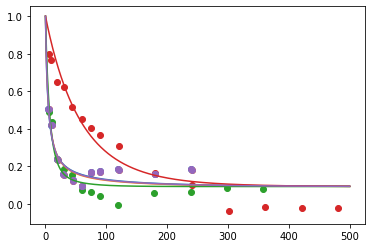

In [7]:
guess = [1,0.001]
x_fit = {}
y_fit = {}
p = {} # parameters
for key in asa_data.keys():
        constants, _ = optimize.curve_fit(func, asa_data[key]['t'].tolist(), asa_data[key]['v'].tolist(), p0 = guess)
        p.update({key:{'bi':constants[0], 'd_r2':constants[1]}})
        x_fit.update({key: np.linspace(0.0, 500, 1000)})
        y_fit.update({key: func(x_fit[key], p[key]['bi'], p[key]['d_r2']) })
        plt.scatter(asa_data[key]['t'], asa_data[key]['v'])
        plt.plot(x_fit[key], y_fit[key])
plt.show()

In [8]:
fit_params = pd.DataFrame(p)
print(fit_params)

20mg_1     20mg_2      50mg     100mg       20mg
bi    23.646823  16.351581  3.559804  0.863586  19.803374
d_r2   0.000406   0.000466  0.001370  0.000657   0.000432
